In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from util.plots import scatter_plot

<IPython.core.display.Javascript object>

In [360]:
np.random.seed(seed=42)

CELL_DIMENSION = np.array([16, 16])
orientation = 60
scale = 10
rotation_matrix = np.array(
    [
        [math.cos(orientation), -math.sin(orientation)],
        [math.sin(orientation), math.cos(orientation)],
    ]
)

PHASES_PER_UNIT_DISTANCE = 1.0 / np.array([scale, scale])

<IPython.core.display.Javascript object>

In [361]:
PHASES_PER_UNIT_DISTANCE

array([0.1, 0.1])

<IPython.core.display.Javascript object>

In [362]:
def get_random_phase():
    active_phases = np.random.random(2)

    return active_phases

<IPython.core.display.Javascript object>

In [363]:
def compute_active_cells(active_phases):
    active_cell_coordinates = np.floor(active_phases * CELL_DIMENSION).astype(int)

    cells_for_active_phases = np.ravel_multi_index(
        active_cell_coordinates.T, CELL_DIMENSION
    )

    return cells_for_active_phases

<IPython.core.display.Javascript object>

In [364]:
def compute_movement(displacement: np.ndarray, active_phases):
    phase_displacement = (
        np.matmul(rotation_matrix, displacement) * PHASES_PER_UNIT_DISTANCE
    )

    active_phases = active_phases + phase_displacement

    active_phases = np.round(active_phases, decimals=9)
    active_phases = np.mod(active_phases, 1.0)

    return active_phases

<IPython.core.display.Javascript object>

In [365]:
displacements = np.random.randint(-3, 4, (100000, 2))

<IPython.core.display.Javascript object>

In [366]:
rnd_phase = get_random_phase()
active_cells = [compute_active_cells(rnd_phase)]

active_phase = rnd_phase
for dis in displacements:
    active_phase = compute_movement(dis, active_phase)
    active_cell = compute_active_cells(active_phase)

    active_cells.append(active_cell)

<IPython.core.display.Javascript object>

In [367]:
def calculate_points_from_displacements(displacements):
    xs = [0]
    ys = [0]

    for i in range(len(displacements)):
        xs.append(xs[i] + displacements[i][0])
        ys.append(ys[i] + displacements[i][1])

    return xs, ys

<IPython.core.display.Javascript object>

In [368]:
xs, ys = calculate_points_from_displacements(displacements)

<IPython.core.display.Javascript object>

In [369]:
indices = [i for i, x in enumerate(active_cells) if x == 91]

<IPython.core.display.Javascript object>

In [370]:
xs_filt, ys_filt = zip(*[(xs[i], ys[i]) for i in indices])

<IPython.core.display.Javascript object>

In [371]:
xs_filt

(5,
 5,
 8,
 2,
 2,
 12,
 -1,
 -1,
 -20,
 -20,
 -4,
 -71,
 -29,
 -20,
 12,
 -4,
 15,
 15,
 15,
 9,
 -28,
 60,
 44,
 44,
 39,
 33,
 36,
 20,
 -18,
 -54,
 -79,
 -158,
 -107,
 -87,
 -84,
 -112,
 -172,
 -210,
 -191,
 -157,
 -151,
 -157,
 -154,
 -151,
 -138,
 -161,
 -161,
 -186,
 -154,
 -155,
 -164,
 -123,
 -123,
 -123,
 -123,
 -119,
 -113,
 -34,
 -22,
 45,
 32,
 79,
 29,
 10,
 -41,
 -41,
 -31,
 -31,
 -22,
 19,
 98,
 80,
 80,
 68,
 68,
 58,
 58,
 20,
 30,
 20,
 -11,
 -11,
 -17,
 -17,
 -17,
 -17,
 -11,
 74,
 105,
 133,
 199,
 138,
 154,
 154,
 113,
 141,
 144,
 157,
 157,
 161,
 151,
 198,
 198,
 192,
 180,
 173,
 192,
 229,
 305,
 340,
 397,
 397,
 416,
 422,
 422,
 394,
 340,
 336,
 324,
 327,
 349,
 355,
 406,
 402,
 481,
 519,
 519,
 449,
 430,
 424,
 437,
 452,
 417,
 442,
 429,
 398,
 398,
 420,
 401,
 401,
 366,
 366,
 316,
 291,
 341,
 344,
 328,
 347,
 334,
 382,
 385,
 369,
 360,
 360,
 376,
 398,
 394,
 388,
 410,
 461,
 483,
 423,
 429,
 357,
 388,
 398,
 398,
 429,
 413,
 442,
 

<IPython.core.display.Javascript object>

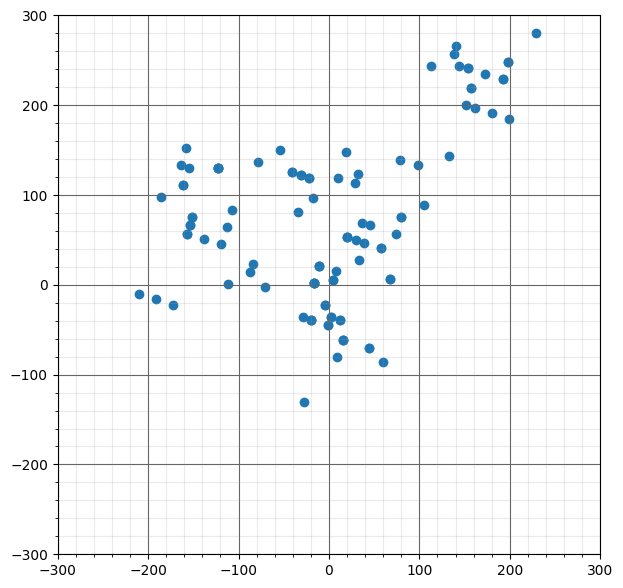

<IPython.core.display.Javascript object>

In [372]:
scatter_plot(xs_filt, ys_filt, lim=(-300, 300))

In [355]:
x, y = np.unravel_index(active_cells, CELL_DIMENSION)

<IPython.core.display.Javascript object>

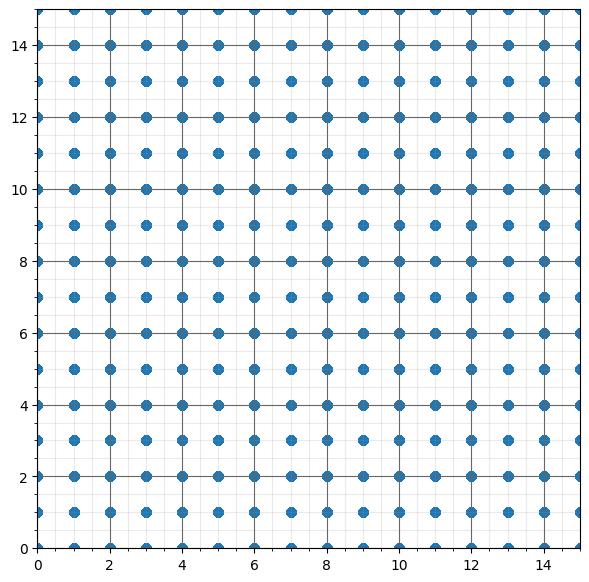

<IPython.core.display.Javascript object>

In [356]:
scatter_plot(x, y, lim=(0, 15))